<h1 style="text-align: center;"><a href="https://www.whatwouldaithink.com">WhatWouldAiThink.com</a></h1>


<h3 style="text-align: center;">Classification of Cats and Dogs</h3>

<h3 style="text-align: center;">April 2024</h3>

<h3 style="text-align: center;">This notebook is made for the analysis of cats and dogs published on:
<a href="https://www.whatwouldaithink.com">whatwouldaithink.com</a></h3>
<h4 style="text-align: center;">Copyright © 2022-Present whatwouldaithink.com - All Rights Reserved</h4>

<h1 style="text-align: center;"> Train a CNN with images with edges </h1>

In [1]:
# import basics
import os
from pathlib import Path
import time

# import torch
import torch
from random import randrange
torch.manual_seed(0)

# custom modules
import sys
sys.path.append('..')
from printing.customPrinting import info
from vision.Definitions import *
from vision.Utils import printNumOfLearnableWeights, findOptimumBatchSize
from vision.Utils import readDataToDataFrame, createDirectories
from vision.TransformImages import TransformImages
from vision.Data import Data
from vision.Models import CNN
from vision.ValidationTools import MyValidator, ValidatePretrainedModel
from vision.TrainModels import TrainingManager
# MIN_SIZE_IMAGE is 224, defined in vision.Definitions
pathDataSet = f"datasets"
pathDataSet224x224 = f"datasets{MIN_SIZE_IMAGE[0]}x{MIN_SIZE_IMAGE[1]}"
pathDataSet224x224Edges = f"datasets{MIN_SIZE_IMAGE[0]}x{MIN_SIZE_IMAGE[1]}_edges"

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_columns", 10)

<h1>1. Filter the data for training a CNN </h1>

### Create a new directory and resize the images to MIN_SIZE_IMAGE

In [2]:
# "training_set" and "test_set" are from https://www.kaggle.com/datasets/charmz/cats-and-dogs
# "validate_set" and "validate_set_cropped" are from https://github.com/WhatWouldAiThink/About_Cats_in_Montenegro

# create a new directory with subfolders for images with size MIN_SIZE_IMAGE
folders = ["training_set", 
           "test_set", 
           "validate_set", 
           "validate_set_cropped"]
    
# resize the images and save it in the new directory             
if createDirectories(pathDataSet224x224, folders):
    transformer = TransformImages(pathDataSet, 
                                  pathDataSet224x224,
                                  resize=True, 
                                  size=MIN_SIZE_IMAGE)
    tic = time.time()
    transformer.resize() 
    print(f"Used time: {time.time() - tic}") 

created directory: datasets224x224/training_set/cats
created directory: datasets224x224/training_set/dogs
created directory: datasets224x224/test_set/cats
created directory: datasets224x224/test_set/dogs
created directory: datasets224x224/validate_set/cats
created directory: datasets224x224/validate_set/dogs
created directory: datasets224x224/validate_set_cropped/cats
created directory: datasets224x224/validate_set_cropped/dogs
Used time: 71.76810646057129


### Create a new directory  and convert the images into images with edges

In [3]:
# create a new directory with subfolders to convert all images into images with edges
folders = ["training_set",
            "test_set",
           "validate_set", 
           "validate_set_cropped"]
                     
# transform the images and save it in the new directory 
if createDirectories(pathDataSet224x224Edges, folders):        
    transformer = TransformImages(pathDataSet224x224, 
                                  pathDataSet224x224Edges,)
    tic = time.time()
    transformer.calcEdges(channels=3)   
    print(f"Used time: {time.time() - tic}") 

created directory: datasets224x224_edges/training_set/cats
created directory: datasets224x224_edges/training_set/dogs
created directory: datasets224x224_edges/test_set/cats
created directory: datasets224x224_edges/test_set/dogs
created directory: datasets224x224_edges/validate_set/cats
created directory: datasets224x224_edges/validate_set/dogs
created directory: datasets224x224_edges/validate_set_cropped/cats
created directory: datasets224x224_edges/validate_set_cropped/dogs
Used time: 64.34902882575989


### Create the DataFrames for images with edges with image size MIN_SIZE_IMAGE

In [4]:
df_train    = readDataToDataFrame(os.path.join(pathDataSet224x224Edges, "training_set"))
df_test     = readDataToDataFrame(os.path.join(pathDataSet224x224Edges, "test_set"))
df_validate = readDataToDataFrame(os.path.join(pathDataSet224x224Edges, "validate_set"))
df_validateCropped = readDataToDataFrame(os.path.join(pathDataSet224x224Edges, "validate_set_cropped"))

Reading files from folder: datasets224x224_edges/training_set/cats
Reading files from folder: datasets224x224_edges/training_set/dogs
Reading files from folder: datasets224x224_edges/test_set/cats
Reading files from folder: datasets224x224_edges/test_set/dogs
Reading files from folder: datasets224x224_edges/validate_set/cats
Reading files from folder: datasets224x224_edges/validate_set_cropped/cats


<h3>Create the DataSets</h3>

In [5]:
dataSetTrain = Data(df_train)
dataSetTest = Data(df_test)
dataSetValidate = Data(df_validate)
dataSetValidateCropped = Data(df_validateCropped)

### Plot images for all DataSets to check that all images are images with edges

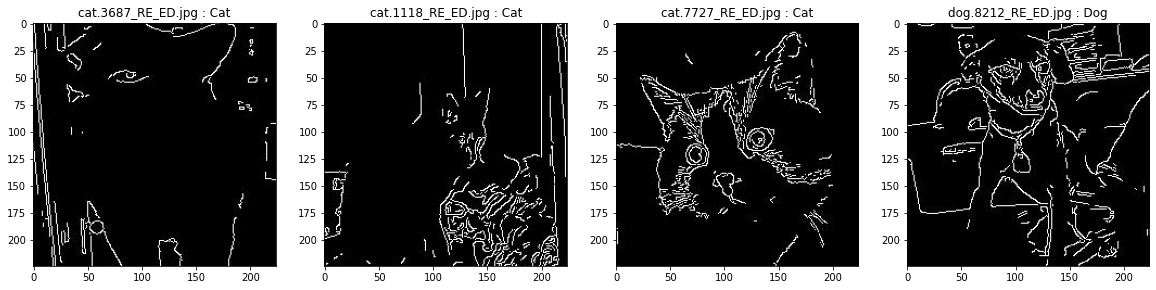

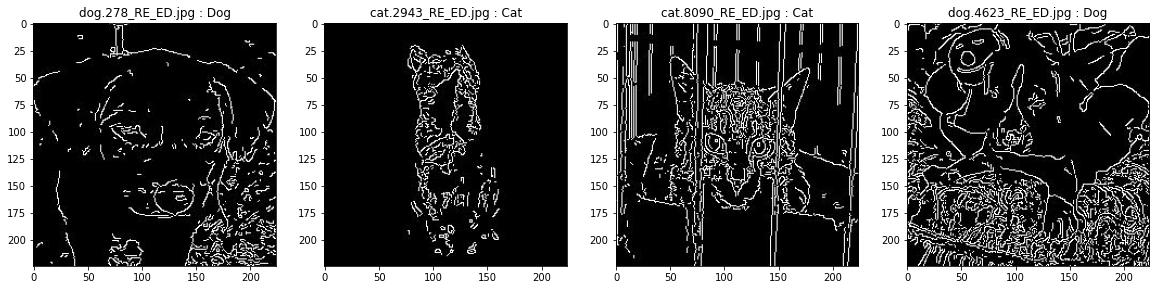

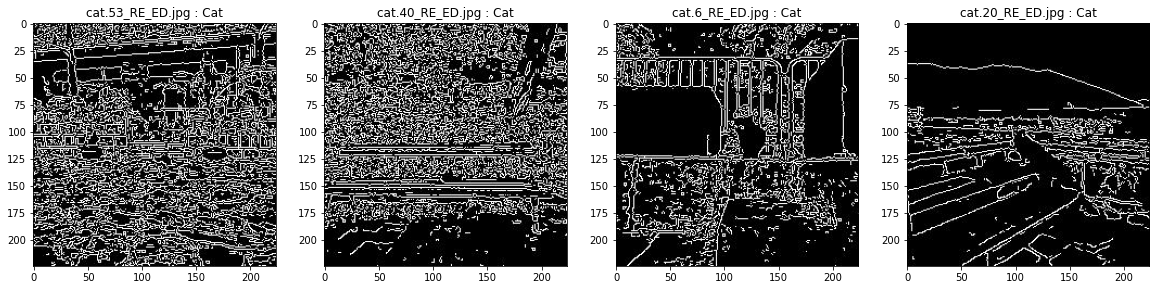

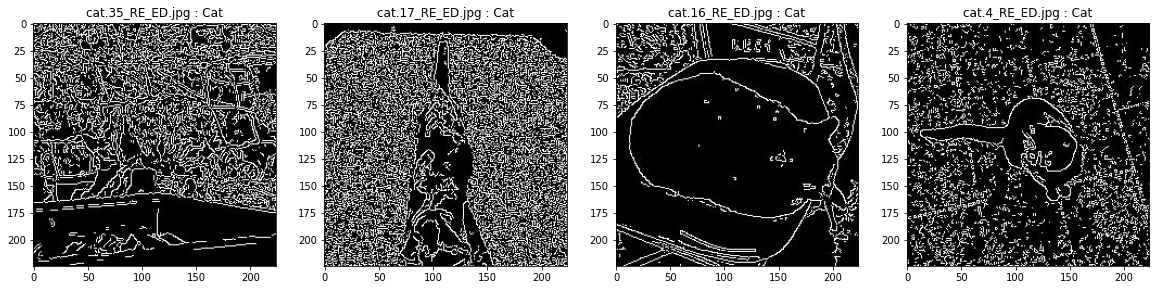

In [6]:
for dataSet in [dataSetTrain, dataSetTest, dataSetValidate, dataSetValidateCropped]:
    rows = dataSet.__len__()    
    dataSet.plotImages([randrange(0, rows) for _ in range(4)])    

<h1>2. Train a CNN with images with edges</h1>

In [7]:
# define the params for the convolution layers
conv1 = {"inChannels" : 3, "outChannels" : 32,
         "cKernel" : 5, "cStride" : 1, "cPadding" : 2}
conv2 = {"inChannels" : 32, "outChannels" : 64,
         "cKernel" : 5, "cStride" : 1, "cPadding" : 2}
conv3 = {"inChannels" : 64, "outChannels" : 128,
         "cKernel" : 5, "cStride" : 1, "cPadding" : 2}
conv4 = {"inChannels" : 128, "outChannels" : 256,
         "cKernel" : 5, "cStride" : 1, "cPadding" : 2}
conv5 = {"inChannels" : 256, "outChannels" : 512,
         "cKernel" : 5, "cStride" : 1, "cPadding" : 2}
    
# create the model    
model = CNN(imageSize=MIN_SIZE_IMAGE,
              convLayers=[conv1, conv2, conv3, conv4, conv5], 
              fullConLayers=[1],              
              dropOut=0.5)

printNumOfLearnableWeights(model)
display(model)

Creating a CNN with the following architecture:

Convolution Layer: 0
Channels in: 3
Channels out: 32
Reading default parameters for max pooling
Size Image out Conv: (224, 224)
Size Image out MaxPool: (112, 112)

Convolution Layer: 1
Channels in: 32
Channels out: 64
Reading default parameters for max pooling
Size Image out Conv: (112, 112)
Size Image out MaxPool: (56, 56)

Convolution Layer: 2
Channels in: 64
Channels out: 128
Reading default parameters for max pooling
Size Image out Conv: (56, 56)
Size Image out MaxPool: (28, 28)

Convolution Layer: 3
Channels in: 128
Channels out: 256
Reading default parameters for max pooling
Size Image out Conv: (28, 28)
Size Image out MaxPool: (14, 14)

Convolution Layer: 4
Channels in: 256
Channels out: 512
Reading default parameters for max pooling
Size Image out Conv: (14, 14)
Size Image out MaxPool: (7, 7)

Fully connected layer: 0
Number of Neurons: 1

Setting criterion to BinaryCrossEntropyLoss!
Number of trainable weights: 4382467


CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14)

Number of samples for train: 17650
Number of samples for test: 4395
Number of samples for vali: 61
Number of samples for valiCrop: 61

File checkpoint_Edges.pt or checkpoint_Edges_best.pt already exist.
ONLY RESUME TRAINING POSSIBLE!!!.


Loading checkpoint: checkpoint_Edges.pt
checkpoint[epoch]: 50

Loading checkpoint['accuracy_lists']
valiCrop : [0.32786885245901637, 0.19672131147540983, 0.2786885245901639, 0.22950819672131148, 0.22950819672131148, 0.39344262295081966, 0.16393442622950818, 0.19672131147540983, 0.18032786885245902, 0.6721311475409836, 0.36065573770491804, 0.16393442622950818, 0.32786885245901637, 0.08196721311475409, 0.3114754098360656, 0.26229508196721313, 0.2459016393442623, 0.3770491803278688, 0.21311475409836064, 0.22950819672131148, 0.32786885245901637, 0.14754098360655737, 0.2786885245901639, 0.2459016393442623, 0.29508196721311475, 0.47540983606557374, 0.26229508196721313, 0.26229508196721313, 0.26229508196721313, 0.5081967213114754, 0.3770491803278688, 0.37704

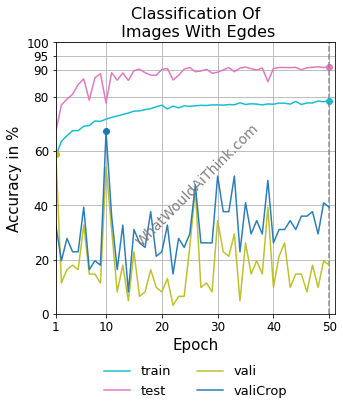

In [8]:
# Train the model
checkpoint="Edges"
tm = TrainingManager(lr=0.001, model=model, nameCheckpoint=checkpoint, 
                     batchSize=32, criterion=model.criterion, 
                     datasets={"train": dataSetTrain, 
                      "test": dataSetTest,
                      "vali": dataSetValidate,
                      "valiCrop": dataSetValidateCropped},
                      title="Classification Of\n Images With Egdes")

n_epochs = 0
tm.resume(n_epochs)

### Test the trained CNN with the test set


Loading checkpoint: checkpoint_Edges_best.pt
Found    4003    true classified images in 4395 images.
Found    392     false classified images in 4395 images.

Confusion Matrix: [[1990  207]
 [ 185 2013]]
Found    1990    images classified as trueDog    in 4395 images.
Found    207     images classified as falseCat   in 4395 images.
Found    185     images classified as falseDog   in 4395 images.
Found    2013    images classified as trueCat    in 4395 images.


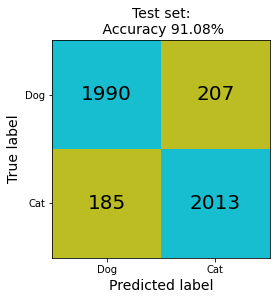

In [9]:
checkPointBest = f"checkpoint_{checkpoint}_best.pt"
validator = MyValidator(model, checkPointBest, dataSetTest,labelDic, "Test set")
validator.plotConfusionMatrix("Test set", f"CMatrixTestSetResults{checkpoint}")

### Validate the trained CNN with the validation sets


Loading checkpoint: checkpoint_Edges_best.pt
Found     11     true classified images in 61 images.
Found     50     false classified images in 61 images.

Confusion Matrix: [[ 0  0]
 [50 11]]
Found     0      images classified as trueDog    in 61 images.
Found     0      images classified as falseCat   in 61 images.
Found     50     images classified as falseDog   in 61 images.
Found     11     images classified as trueCat    in 61 images.


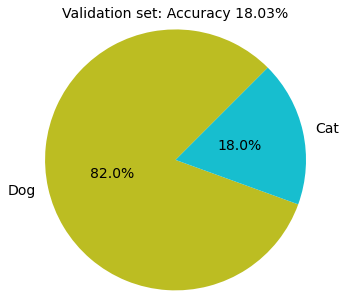

In [10]:
validator = MyValidator(model, checkPointBest, dataSetValidate, labelDic, "Validation set")
validator.plotPie("Validation set", f"PieChartValiSetResults{checkpoint}")


Loading checkpoint: checkpoint_Edges_best.pt
Found     24     true classified images in 61 images.
Found     37     false classified images in 61 images.

Confusion Matrix: [[ 0  0]
 [37 24]]
Found     0      images classified as trueDog    in 61 images.
Found     0      images classified as falseCat   in 61 images.
Found     37     images classified as falseDog   in 61 images.
Found     24     images classified as trueCat    in 61 images.


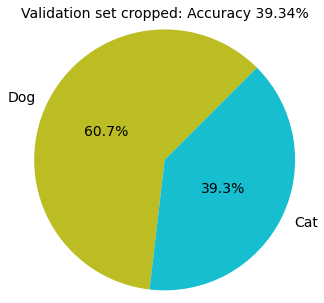

In [11]:
validator = MyValidator(model, checkPointBest, dataSetValidateCropped, labelDic, "Validation set cropped")
validator.plotPie("Validation set cropped", f"PieChartValiSetCroppedResults{checkpoint}")

### Plot some false and true classified images

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


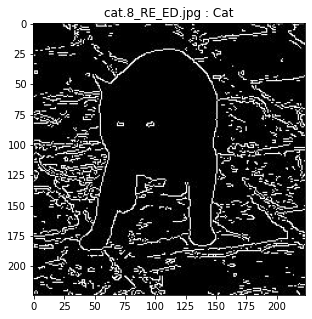

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


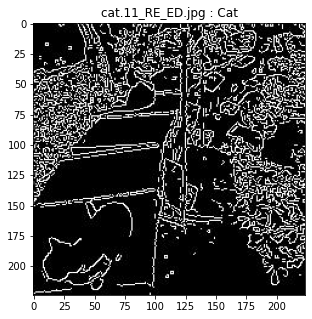

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


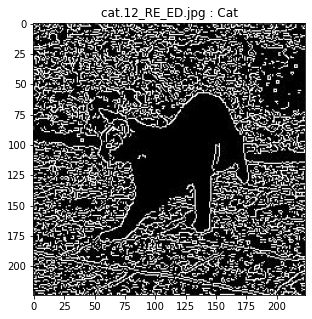

In [12]:
validator.plotClassifiedImages("False", 3)

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


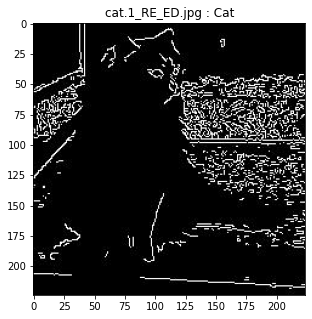

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


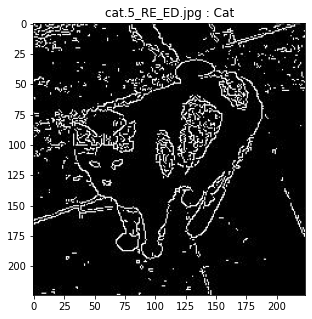

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


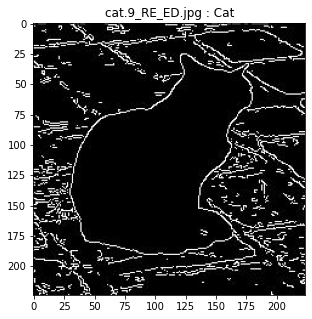

In [13]:
validator.plotClassifiedImages("True", 3)